In [34]:
#Könyvtár behívása
import pandas as pd

In [35]:
#Adathalmaz beolvasása
root = r"bank+marketing\bank\bank-full.csv"
ah = pd.read_csv(root, sep=';')

In [36]:
#Adathalmaz elemzése
print(f"Sorok: {len(ah)}")
print(f"Változók (oszlopok száma): {len(ah.columns)}")
print(ah.head())
print(ah.describe())
print(ah['job'].value_counts())
print(ah['balance'].describe())

Sorok: 45211
Változók (oszlopok száma): 17
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
                age        balance           day      duration      

In [37]:
"""
DBSCAN Klaszterezés - Banki Ügyfélszegmentáció
Sűrűség-alapú klaszterezési módszer outlier detektálással
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Betűtípus beállítása
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("DBSCAN KLASZTEREZÉS - SŰRŰSÉG-ALAPÚ SZEGMENTÁCIÓ")
print("=" * 80)

# MINTAVÉTEL nagy adathalmaznál (gyorsaság és memória miatt)
SAMPLE_SIZE = 15000
if len(ah) > SAMPLE_SIZE:
    print(f"⚠ Mintavétel: {len(ah):,} → {SAMPLE_SIZE:,} sor")
    ah = ah.sample(n=SAMPLE_SIZE, random_state=42).copy()

print(f"Változók: {list(ah.columns)}")
print(f"Feldolgozott minta: {len(ah):,} ügyfél")

# ============================================================================
# 2. ADATOK STANDARDIZÁLÁSA
# ============================================================================
print("\n📊 ADATOK STANDARDIZÁLÁSA")
print("-" * 80)

X = ah[['age', 'balance']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Eredeti skála:")
print(f"  Életkor: {ah['age'].min():.1f} - {ah['age'].max():.1f} év")
print(f"  Egyenleg: {ah['balance'].min():,.0f} - {ah['balance'].max():,.0f} €")
print(f"Standardizált skála: átlag=0, szórás=1")

DBSCAN KLASZTEREZÉS - SŰRŰSÉG-ALAPÚ SZEGMENTÁCIÓ
⚠ Mintavétel: 45,211 → 15,000 sor
Változók: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
Feldolgozott minta: 15,000 ügyfél

📊 ADATOK STANDARDIZÁLÁSA
--------------------------------------------------------------------------------
Eredeti skála:
  Életkor: 18.0 - 93.0 év
  Egyenleg: -8,019 - 102,127 €
Standardizált skála: átlag=0, szórás=1



K-DISTANCE MÓDSZER - EPSILON BECSLÉS
MinPts (min_samples): 10
🔍 K-distance számítás...
📊 K-distance javaslat: eps ≈ 0.7858


C:\Users\Balázs\AppData\Local\Temp\ipykernel_125496\1894534443.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  k_distances_smooth = k_distances_smooth.fillna(method='bfill').fillna(method='ffill')


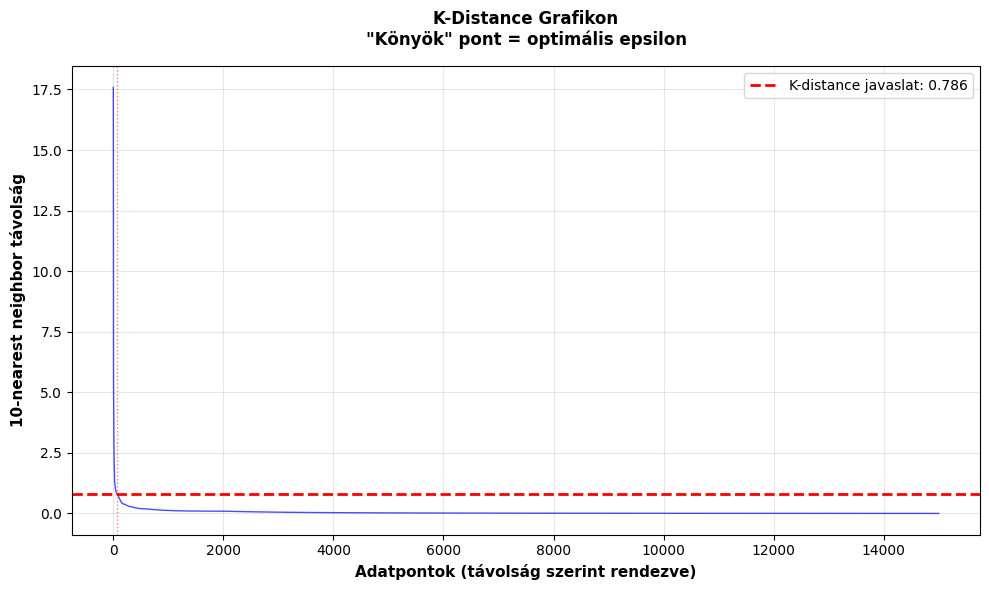

In [44]:
# ============================================================================
# 3. K-DISTANCE MÓDSZER
# ============================================================================
print("\n" + "=" * 80)
print("K-DISTANCE MÓDSZER - EPSILON BECSLÉS")
print("=" * 80)

min_samples = 10
print(f"MinPts (min_samples): {min_samples}")

# K-distance számítás
print("🔍 K-distance számítás...")
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# K-adik legközelebbi szomszéd távolsága
k_distances = np.sort(distances[:, -1])[::-1]

# KÖNYÖK PONT DETEKTÁLÁS
# Módszer 1: Második derivált maximum
if len(k_distances) > 100:
    # Simítás (rolling average)
    window_size = max(10, len(k_distances) // 100)
    k_distances_smooth = pd.Series(k_distances).rolling(window=window_size, center=True).mean()
    k_distances_smooth = k_distances_smooth.fillna(method='bfill').fillna(method='ffill')
    
    # Első derivált
    first_deriv = np.diff(k_distances_smooth)
    
    # Második derivált (gyorsulás változása)
    second_deriv = np.diff(first_deriv)
    
    # Könyök pont = legnagyobb második derivált változás
    # De csak az első 10%-ban keressük
    search_range = len(second_deriv) // 10
    knee_point = np.argmax(np.abs(second_deriv[:search_range]))
    
    suggested_eps_kdist = k_distances[knee_point]
else:
    # Kis adathalmaz esetén egyszerű módszer
    diffs = np.diff(k_distances)
    knee_point = np.argmax(diffs)
    suggested_eps_kdist = k_distances[knee_point]

print(f"📊 K-distance javaslat: eps ≈ {suggested_eps_kdist:.4f}")

# K-distance grafikon
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(k_distances)), k_distances, 'b-', linewidth=1, alpha=0.7)
ax.axhline(y=suggested_eps_kdist, color='r', linestyle='--', linewidth=2, 
           label=f'K-distance javaslat: {suggested_eps_kdist:.3f}')
ax.axvline(x=knee_point, color='r', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Adatpontok (távolság szerint rendezve)', fontsize=11, fontweight='bold')
ax.set_ylabel(f'{min_samples}-nearest neighbor távolság', fontsize=11, fontweight='bold')
ax.set_title('K-Distance Grafikon\n"Könyök" pont = optimális epsilon', 
             fontsize=12, fontweight='bold', pad=15)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('/mnt/user-data/outputs/dbscan_kdistance_javitott.png', dpi=300, bbox_inches='tight')
#print("✓ K-distance grafikon mentve: dbscan_kdistance_javitott.png")


In [45]:
# ============================================================================
# 3. EPSILON TESZTELÉS ÉS INTELLIGENS KIVÁLASZTÁS
# ============================================================================
print("\n" + "=" * 80)
print("EPSILON PARAMÉTER TESZTELÉSE")
print("=" * 80)

# Tesztelendő értékek a K-distance javaslat körül
eps_center = suggested_eps_kdist
eps_values = [
    eps_center * 0.6,
    eps_center * 0.8,
    eps_center * 1.0,
    eps_center * 1.2,
    eps_center * 1.5
]
eps_values = [round(e, 2) for e in eps_values]  # Kerekítés

print(f"\nTesztelt eps értékek (K-distance javaslat: {suggested_eps_kdist:.3f}):")
print(f"{'eps':>6} | {'Klaszterek':>12} | {'Zajpontok':>12} | {'Zaj %':>8}")
print("-" * 60)

test_results = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_pct = (n_noise / len(labels)) * 100
    
    test_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct
    })
    
    print(f"{eps:>6.2f} | {n_clusters:>12} | {n_noise:>12,} | {noise_pct:>7.2f}%")

# ============================================================================
# 4. INTELLIGENS EPS KIVÁLASZTÁS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMÁLIS EPSILON KIVÁLASZTÁSA")
print("=" * 80)

test_df = pd.DataFrame(test_results)

# SCORING RENDSZER (minél magasabb, annál jobb)
def score_eps_result(row):
    """
    Pontozási rendszer az optimális eps kiválasztásához
    """
    score = 0
    
    # 1. Klaszterszám (2-5 klaszter ideális)
    if 2 <= row['n_clusters'] <= 3:
        score += 40  # Legjobb: 2-3 klaszter
    elif 4 <= row['n_clusters'] <= 5:
        score += 30  # Jó: 4-5 klaszter
    elif row['n_clusters'] == 1:
        score += 5   # Gyenge: 1 klaszter
    elif row['n_clusters'] > 10:
        score += 0   # Rossz: túl sok klaszter
    else:
        score += 20  # Közepes: 6-10 klaszter
    
    # 2. Zajpont arány (0.5-2% ideális)
    if 0.5 <= row['noise_pct'] <= 2.0:
        score += 40  # Ideális zajpont arány
    elif 0.2 <= row['noise_pct'] <= 5.0:
        score += 30  # Elfogadható
    elif row['noise_pct'] < 0.1:
        score += 10  # Túl kevés zaj (lehet hogy túl nagy eps)
    else:
        score += 5   # Túl sok zaj
    
    # 3. Bónusz: Ha közel van a K-distance javaslathoz
    distance_from_kdist = abs(row['eps'] - suggested_eps_kdist)
    if distance_from_kdist < 0.05:
        score += 20  # Nagyon közel
    elif distance_from_kdist < 0.10:
        score += 10  # Közel
    
    return score

# Pontozás minden eps-re
test_df['score'] = test_df.apply(score_eps_result, axis=1)

# Legjobb eps kiválasztása
best_row = test_df.loc[test_df['score'].idxmax()]
best_eps = best_row['eps']

print("\nPONTOZÁS EREDMÉNYEI:")
print(test_df[['eps', 'n_clusters', 'noise_pct', 'score']].to_string(index=False))

print(f"\n✅ VÁLASZTOTT EPSILON: {best_eps}")
print(f"   Klaszterek: {best_row['n_clusters']}")
print(f"   Zajpontok: {int(best_row['n_noise'])} ({best_row['noise_pct']:.2f}%)")
print(f"   Pontszám: {best_row['score']}/100")


EPSILON PARAMÉTER TESZTELÉSE

Tesztelt eps értékek (K-distance javaslat: 0.786):
   eps |   Klaszterek |    Zajpontok |    Zaj %
------------------------------------------------------------
  0.47 |            1 |          116 |    0.77%
  0.63 |            2 |           84 |    0.56%
  0.79 |            1 |           37 |    0.25%
  0.94 |            1 |           29 |    0.19%
  1.18 |            1 |           22 |    0.15%

OPTIMÁLIS EPSILON KIVÁLASZTÁSA

PONTOZÁS EREDMÉNYEI:
 eps  n_clusters  noise_pct  score
0.47           1   0.773333     45
0.63           2   0.560000     80
0.79           1   0.246667     55
0.94           1   0.193333     10
1.18           1   0.146667     10

✅ VÁLASZTOTT EPSILON: 0.63
   Klaszterek: 2.0
   Zajpontok: 84 (0.56%)
   Pontszám: 80.0/100


In [46]:
# ============================================================================
# 5. VÉGLEGES DBSCAN FUTTATÁSA
# ============================================================================
print("\n" + "=" * 80)
print("VÉGLEGES DBSCAN KLASZTEREZÉS")
print("=" * 80)

dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
ah['cluster'] = dbscan.fit_predict(X_scaled)

# Statisztikák
n_clusters = len(set(ah['cluster'])) - (1 if -1 in ah['cluster'].values else 0)
n_noise = list(ah['cluster']).count(-1)
n_noise_pct = (n_noise / len(ah)) * 100

print(f"\nParaméterek:")
print(f"  Epsilon (eps): {best_eps}")
print(f"  MinPts (min_samples): {min_samples}")
print(f"\nEredmények:")
print(f"  Klaszterek száma: {n_clusters}")
print(f"  Zajpontok: {n_noise:,} ({n_noise_pct:.2f}%)")
print(f"  Klaszterezett: {len(ah) - n_noise:,} ({100 - n_noise_pct:.2f}%)")



VÉGLEGES DBSCAN KLASZTEREZÉS

Paraméterek:
  Epsilon (eps): 0.63
  MinPts (min_samples): 10

Eredmények:
  Klaszterek száma: 2
  Zajpontok: 84 (0.56%)
  Klaszterezett: 14,916 (99.44%)


In [47]:
# ============================================================================
# 6. KLASZTER STATISZTIKÁK
# ============================================================================
print("\n" + "=" * 80)
print("KLASZTER STATISZTIKÁK")
print("=" * 80)

# Zajpontok
if n_noise > 0:
    noise_data = ah[ah['cluster'] == -1]
    print(f"\n{'='*50}")
    print(f"ZAJPONTOK (Outliers)")
    print(f"{'='*50}")
    print(f"Méret:      {len(noise_data):>8,} elem ({n_noise_pct:>5.2f}%)")
    print(f"Életkor:    {noise_data['age'].mean():>8.2f} ± {noise_data['age'].std():.2f} év")
    print(f"Egyenleg:   {noise_data['balance'].mean():>8,.0f} ± {noise_data['balance'].std():,.0f} €")

# Valódi klaszterek
cluster_ids = sorted([c for c in ah['cluster'].unique() if c != -1])

for i, cluster_id in enumerate(cluster_ids):
    cluster_data = ah[ah['cluster'] == cluster_id]
    count = len(cluster_data)
    percentage = (count / len(ah)) * 100
    
    print(f"\n{'='*50}")
    print(f"{i+1}. KLASZTER")
    print(f"{'='*50}")
    print(f"Méret:      {count:>8,} elem ({percentage:>5.2f}%)")
    print(f"Életkor:    {cluster_data['age'].mean():>8.2f} ± {cluster_data['age'].std():.2f} év")
    print(f"Egyenleg:   {cluster_data['balance'].mean():>8,.0f} ± {cluster_data['balance'].std():,.0f} €")
    
    # Jellemzés
    if cluster_data['balance'].mean() > 10000:
        jellemzes = "VIP / Magas vagyonú szegmens"
    elif cluster_data['balance'].mean() > 2500:
        jellemzes = "Közepes-magas egyenlegű"
    else:
        jellemzes = "Átlagos / Alacsony egyenlegű"
    print(f"Jellemzés:  {jellemzes}")


KLASZTER STATISZTIKÁK

ZAJPONTOK (Outliers)
Méret:            84 elem ( 0.56%)
Életkor:       51.55 ± 14.61 év
Egyenleg:     27,824 ± 16,746 €

1. KLASZTER
Méret:        14,911 elem (99.41%)
Életkor:       40.86 ± 10.55 év
Egyenleg:      1,228 ± 2,180 €
Jellemzés:  Átlagos / Alacsony egyenlegű

2. KLASZTER
Méret:             5 elem ( 0.03%)
Életkor:       57.40 ± 2.88 év
Egyenleg:     19,160 ± 592 €
Jellemzés:  VIP / Magas vagyonú szegmens



VIZUALIZÁCIÓ KÉSZÍTÉSE
✓ Scatter plot mentve: dbscan_scatter.png
✓ Kombinált ábra mentve: dbscan_final.png


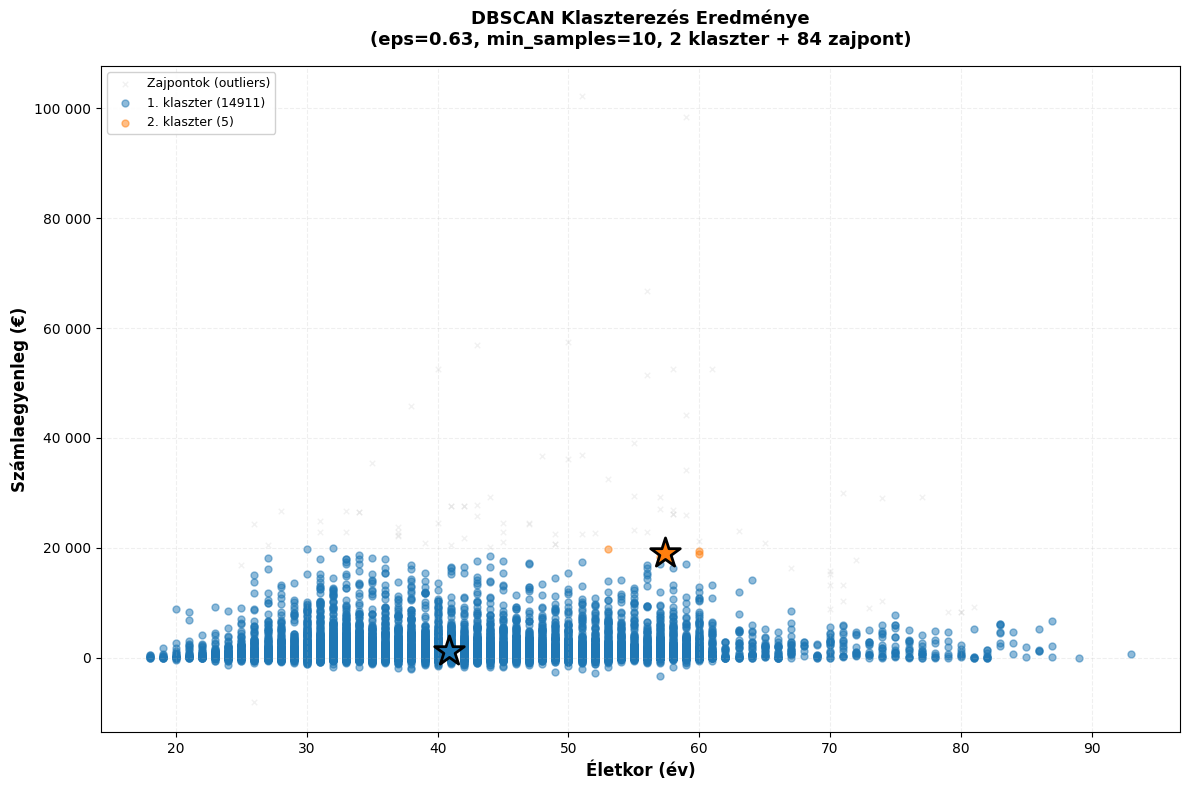

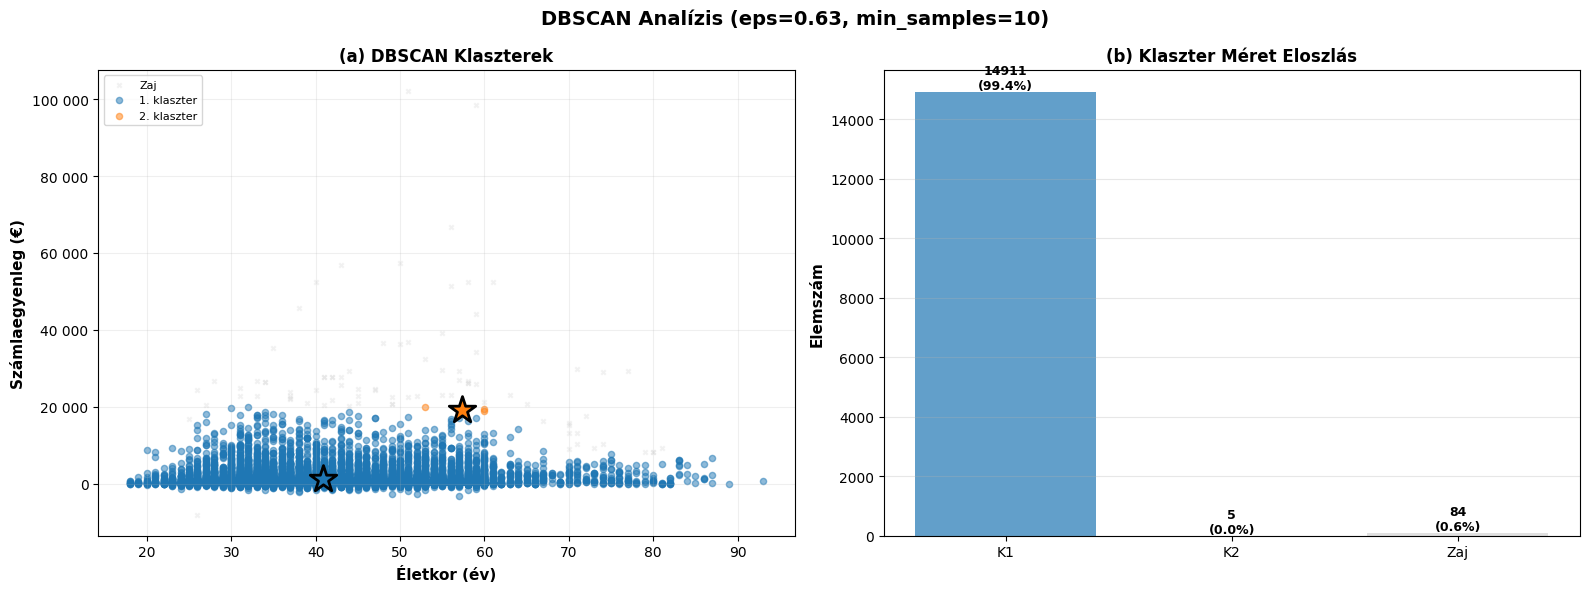

In [48]:
# ============================================================================
# 7. VIZUALIZÁCIÓ
# ============================================================================
print("\n" + "=" * 80)
print("VIZUALIZÁCIÓ KÉSZÍTÉSE")
print("=" * 80)

# 7.1. Fő scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Zajpontok
if n_noise > 0:
    noise_data = ah[ah['cluster'] == -1]
    ax.scatter(noise_data['age'], noise_data['balance'], 
               c='lightgray', label='Zajpontok (outliers)', 
               alpha=0.3, s=15, marker='x', linewidths=1)

# Klaszterek
for i, cluster_id in enumerate(cluster_ids):
    cluster_data = ah[ah['cluster'] == cluster_id]
    color = colors[i % len(colors)]
    ax.scatter(cluster_data['age'], cluster_data['balance'], 
               c=color, label=f'{i+1}. klaszter ({len(cluster_data)})', 
               alpha=0.5, s=25)
    
    # Középpont jelzés
    cx = cluster_data['age'].mean()
    cy = cluster_data['balance'].mean()
    ax.scatter(cx, cy, c=color, marker='*', s=500, 
               edgecolors='black', linewidths=2, zorder=10)

ax.set_xlabel('Életkor (év)', fontsize=12, fontweight='bold')
ax.set_ylabel('Számlaegyenleg (€)', fontsize=12, fontweight='bold')
ax.set_title(f'DBSCAN Klaszterezés Eredménye\n(eps={best_eps}, min_samples={min_samples}, {n_clusters} klaszter + {n_noise} zajpont)', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))

plt.tight_layout()
plt.savefig('ábrák/dbscan_scatter.png', dpi=300, bbox_inches='tight')
print("✓ Scatter plot mentve: dbscan_scatter.png")

# 7.2. Kombinált ábra
fig = plt.figure(figsize=(16, 6))

# Subplot 1: Scatter plot
ax1 = plt.subplot(1, 2, 1)

if n_noise > 0:
    noise_data = ah[ah['cluster'] == -1]
    ax1.scatter(noise_data['age'], noise_data['balance'], 
               c='lightgray', label='Zaj', alpha=0.3, s=10, marker='x')

for i, cluster_id in enumerate(cluster_ids):
    cluster_data = ah[ah['cluster'] == cluster_id]
    color = colors[i % len(colors)]
    ax1.scatter(cluster_data['age'], cluster_data['balance'], 
               c=color, label=f'{i+1}. klaszter', alpha=0.5, s=20)
    
    cx, cy = cluster_data['age'].mean(), cluster_data['balance'].mean()
    ax1.scatter(cx, cy, c=color, marker='*', s=400, 
               edgecolors='black', linewidths=2, zorder=10)

ax1.set_xlabel('Életkor (év)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Számlaegyenleg (€)', fontsize=11, fontweight='bold')
ax1.set_title(f'(a) DBSCAN Klaszterek', fontsize=12, fontweight='bold')
ax1.legend(fontsize=8, loc='upper left')
ax1.grid(True, alpha=0.2)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))


# Subplot 2: Klaszter méretek
ax2 = plt.subplot(1, 2, 2)

cluster_sizes = []
cluster_names = []

for i, cluster_id in enumerate(cluster_ids):
    size = len(ah[ah['cluster'] == cluster_id])
    cluster_sizes.append(size)
    cluster_names.append(f'K{i+1}')

if n_noise > 0:
    cluster_sizes.append(n_noise)
    cluster_names.append('Zaj')
    colors_bar = colors[:len(cluster_ids)] + ['lightgray']
else:
    colors_bar = colors[:len(cluster_ids)]

bars = ax2.bar(range(len(cluster_sizes)), cluster_sizes, 
              color=colors_bar, alpha=0.7)
ax2.set_xticks(range(len(cluster_sizes)))
ax2.set_xticklabels(cluster_names, fontsize=10)
ax2.set_ylabel('Elemszám', fontsize=11, fontweight='bold')
ax2.set_title('(b) Klaszter Méret Eloszlás', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Értékek a bárokon
for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
    height = bar.get_height()
    pct = size / len(ah) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{size}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle(f'DBSCAN Analízis (eps={best_eps}, min_samples={min_samples})', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ábrák/dbscan_final.png', dpi=300, bbox_inches='tight')
print("✓ Kombinált ábra mentve: dbscan_final.png")



In [49]:
# ============================================================================
# 8. EREDMÉNYEK MENTÉSE
# ============================================================================
print("\n" + "=" * 80)
print("EREDMÉNYEK MENTÉSE")
print("=" * 80)

# CSV mentés
ah.to_csv('ábrák/dbscan_results.csv', index=False, encoding='utf-8-sig')
print("✓ dbscan_results.csv")

# Paraméter tesztek
test_df.to_csv('ábrák/dbscan_parameters.csv', index=False)
print("✓ dbscan_parameters.csv")

# Statisztikák szöveges fájlba
with open('ábrák/dbscan_statistics.txt', 'w', encoding='utf-8') as f:
    f.write("DBSCAN KLASZTEREZÉSI STATISZTIKÁK\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Generálva: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"PARAMÉTEREK:\n")
    f.write(f"  Epsilon: {best_eps}\n")
    f.write(f"  MinPts: {min_samples}\n\n")
    f.write(f"EREDMÉNYEK:\n")
    f.write(f"  Klaszterek: {n_clusters}\n")
    f.write(f"  Zajpontok: {n_noise:,} ({n_noise_pct:.2f}%)\n")
    f.write(f"  Klaszterezett: {len(ah) - n_noise:,}\n\n")
    
    if n_noise > 0:
        noise_data = ah[ah['cluster'] == -1]
        f.write(f"ZAJPONTOK:\n")
        f.write(f"  Életkor: {noise_data['age'].mean():.2f} ± {noise_data['age'].std():.2f}\n")
        f.write(f"  Egyenleg: {noise_data['balance'].mean():,.0f} ± {noise_data['balance'].std():,.0f}\n\n")
    
    for i, cluster_id in enumerate(cluster_ids):
        cluster_data = ah[ah['cluster'] == cluster_id]
        pct = len(cluster_data) / len(ah) * 100
        f.write(f"{i+1}. KLASZTER ({len(cluster_data):,} elem, {pct:.2f}%)\n")
        f.write("-" * 80 + "\n")
        f.write(f"  Életkor: {cluster_data['age'].mean():.2f} ± {cluster_data['age'].std():.2f}\n")
        f.write(f"  Egyenleg: {cluster_data['balance'].mean():,.0f} ± {cluster_data['balance'].std():,.0f}\n\n")

print("✓ dbscan_statistics.txt")

print("\n" + "=" * 80)
print("✅ DBSCAN KLASZTEREZÉS SIKERESEN BEFEJEZVE!")
print("=" * 80)
print(f"\n📊 Összefoglalás:")
print(f"  • {n_clusters} klaszter azonosítva")
print(f"  • {n_noise:,} zajpont detektálva ({n_noise_pct:.2f}%)")
print(f"  • Paraméterek: eps={best_eps}, min_samples={min_samples}")
print(f"  • 4 fájl generálva (2 PNG, 2 CSV)")


EREDMÉNYEK MENTÉSE
✓ dbscan_results.csv
✓ dbscan_parameters.csv
✓ dbscan_statistics.txt

✅ DBSCAN KLASZTEREZÉS SIKERESEN BEFEJEZVE!

📊 Összefoglalás:
  • 2 klaszter azonosítva
  • 84 zajpont detektálva (0.56%)
  • Paraméterek: eps=0.63, min_samples=10
  • 4 fájl generálva (2 PNG, 2 CSV)
